In [131]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [0]:
%reload_ext google.colab.data_table

In [0]:
project_id = 'subtle-signal-258712'

In [134]:
%env GCLOUD_PROJECT=subtle-signal-258712

env: GCLOUD_PROJECT=subtle-signal-258712


In [135]:
%%bigquery --project subtle-signal-258712 --use_legacy_sql
SELECT 
  COUNT(*) as total_rows
FROM [bigquery-public-data:samples.gsod]

,total_rows
0,114420316


In [136]:
from google.cloud import bigquery

client = bigquery.Client(project= 'subtle-signal-258712')

row_count = client.query('''
    SELECT
      COUNT(*) as total
    FROM `genomics-public-data.1000_genomes.sample_info`
''').to_dataframe().total[0]

print('Full dataset has %d rows' % row_count)

Full dataset has 3500 rows


In [0]:
"""
Helper class to simplify common read-only BigQuery tasks.
"""
import pandas as pd
import time

from google.cloud import bigquery

class BigQueryHelper(object):
    """
    Helper class to simplify common BigQuery tasks like executing queries,
    showing table schemas, etc without worrying about table or dataset pointers.

    See the BigQuery docs for details of the steps this class lets you skip:
    https://googlecloudplatform.github.io/google-cloud-python/latest/bigquery/reference.html
    """

    def __init__(self, active_project, dataset_name, max_wait_seconds=180):
        self.project_name = active_project
        self.dataset_name = dataset_name
        self.max_wait_seconds = max_wait_seconds
        self.client = bigquery.Client()
        self.__dataset_ref = self.client.dataset(self.dataset_name, project=self.project_name)
        self.dataset = None
        self.tables = dict()  # {table name (str): table object}
        self.__table_refs = dict()  # {table name (str): table reference}
        self.total_gb_used_net_cache = 0
        self.BYTES_PER_GB = 2**30

    def __fetch_dataset(self):
        """
        Lazy loading of dataset. For example,
        if the user only calls `self.query_to_pandas` then the
        dataset never has to be fetched.
        """
        if self.dataset is None:
            self.dataset = self.client.get_dataset(self.__dataset_ref)

    def __fetch_table(self, table_name):
        """
        Lazy loading of table
        """
        self.__fetch_dataset()
        if table_name not in self.__table_refs:
            self.__table_refs[table_name] = self.dataset.table(table_name)
        if table_name not in self.tables:
            self.tables[table_name] = self.client.get_table(self.__table_refs[table_name])

    def __handle_record_field(self, row, schema_details, top_level_name=''):
        """
        Unpack a single row, including any nested fields.
        """
        name = row['name']
        if top_level_name != '':
            name = top_level_name + '.' + name
        schema_details.append([{
            'name': name,
            'type': row['type'],
            'mode': row['mode'],
            'fields': pd.np.nan,
            'description': row['description']
                               }])
        # float check is to dodge row['fields'] == np.nan
        if type(row.get('fields', 0.0)) == float:
            return None
        for entry in row['fields']:
            self.__handle_record_field(entry, schema_details, name)

    def __unpack_all_schema_fields(self, schema):
        """
        Unrolls nested schemas. Returns dataframe with one row per field,
        and the field names in the format accepted by the API.
        Results will look similar to the website schema, such as:
            https://bigquery.cloud.google.com/table/bigquery-public-data:github_repos.commits?pli=1

        Args:
            schema: DataFrame derived from api repr of raw table.schema
        Returns:
            Dataframe of the unrolled schema.
        """
        schema_details = []
        schema.apply(lambda row:
            self.__handle_record_field(row, schema_details), axis=1)
        result = pd.concat([pd.DataFrame.from_dict(x) for x in schema_details])
        result.reset_index(drop=True, inplace=True)
        del result['fields']
        return result

    def table_schema(self, table_name):
        """
        Get the schema for a specific table from a dataset.
        Unrolls nested field names into the format that can be copied
        directly into queries. For example, for the `github.commits` table,
        the this will return `committer.name`.

        This is a very different return signature than BigQuery's table.schema.
        """
        self.__fetch_table(table_name)
        raw_schema = self.tables[table_name].schema
        schema = pd.DataFrame.from_dict([x.to_api_repr() for x in raw_schema])
        # the api_repr only has the fields column for tables with nested data
        if 'fields' in schema.columns:
            schema = self.__unpack_all_schema_fields(schema)
        # Set the column order
        schema = schema[['name', 'type', 'mode', 'description']]
        return schema

    def list_tables(self):
        """
        List the names of the tables in a dataset
        """
        self.__fetch_dataset()
        return([x.table_id for x in self.client.list_tables(self.dataset)])

    def estimate_query_size(self, query):
        """
        Estimate gigabytes scanned by query.
        Does not consider if there is a cached query table.
        See https://cloud.google.com/bigquery/docs/reference/rest/v2/jobs#configuration.dryRun
        """
        my_job_config = bigquery.job.QueryJobConfig()
        my_job_config.dry_run = True
        my_job = self.client.query(query, job_config=my_job_config)
        return my_job.total_bytes_processed / self.BYTES_PER_GB

    def query_to_pandas(self, query):
        """
        Execute a SQL query & return a pandas dataframe
        """
        my_job = self.client.query(query)
        start_time = time.time()
        while not my_job.done():
            if (time.time() - start_time) > self.max_wait_seconds:
                print("Max wait time elapsed, query cancelled.")
                self.client.cancel_job(my_job.job_id)
                return None
            time.sleep(0.1)
        # Queries that hit errors will return an exception type.
        # Those exceptions don't get raised until we call my_job.to_dataframe()
        # In that case, my_job.total_bytes_billed can be called but is None
        if my_job.total_bytes_billed:
            self.total_gb_used_net_cache += my_job.total_bytes_billed / self.BYTES_PER_GB
        return my_job.to_dataframe()

    def query_to_pandas_safe(self, query, max_gb_scanned=1):
        """
        Execute a query, but only if the query would scan less than `max_gb_scanned` of data.
        """
        query_size = self.estimate_query_size(query)
        if query_size <= max_gb_scanned:
            return self.query_to_pandas(query)
        msg = "Query cancelled; estimated size of {0} exceeds limit of {1} GB"
        print(msg.format(query_size, max_gb_scanned))

    def head(self, table_name, num_rows=5, start_index=None, selected_columns=None):
        """
        Get the first n rows of a table as a DataFrame.
        Does not perform a full table scan; should use a trivial amount of data as long as n is small.
        """
        self.__fetch_table(table_name)
        active_table = self.tables[table_name]
        schema_subset = None
        if selected_columns:
            schema_subset = [col for col in active_table.schema if col.name in selected_columns]
        results = self.client.list_rows(active_table, selected_fields=schema_subset,
            max_results=num_rows, start_index=start_index)
        results = [x for x in results]
        return pd.DataFrame(
            data=[list(x.values()) for x in results], columns=list(results[0].keys()))

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

**TASK** **2**: **“Data** **Stories** **for** **the** **1000** **Genomes** **Project”**

**2.1** : **EXPLORING PHENOTYPIC DATA** 

Exploring the Sample Information

Ethnicity, gender, and family relationship information is available for the 1,000 Genomes dataset. 
The full 1,000 Genomes dataset has data for 3,500 individuals but the low coverage variant data in table variants is only for a subset of those individuals.


In [0]:
#Creating the helper for our second dataset.
bq_assistant = BigQueryHelper('genomics-public-data','1000_genomes','sample_info')

In [140]:
bq_assistant.list_tables()

['pedigree', 'sample_info', 'variants']

***QUERY*** **1**: COUNT THE NUMBER OF SAMPLES

In [0]:
QUERY ='''SELECT
  COUNT(sample) AS all_samples,
  SUM(IF(In_Phase1_Integrated_Variant_Set = TRUE, 1, 0)) AS samples_in_variants_table
FROM
  `genomics-public-data.1000_genomes.sample_info` 
  '''

In [142]:
bq_assistant.estimate_query_size(QUERY)

3.0353665351867676e-05

In [0]:
df = bq_assistant.query_to_pandas_safe(QUERY)

In [144]:
#To explore the results:
print('Size of dataframe: {} Bytes'.format(int(df.memory_usage(index=True, deep=True).sum())))
df.head()

Size of dataframe: 144 Bytes


,all_samples,samples_in_variants_table
0,3500,1092


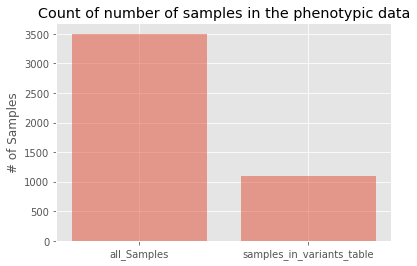

In [145]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

objects = ('all_Samples', 'samples_in_variants_table')
y_pos = np.arange(len(objects))
performance = [df.iloc[0]['all_samples'], df.iloc[0]['samples_in_variants_table']]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('# of Samples')
plt.title('Count of number of samples in the phenotypic data')

plt.show()

***QUERY*** **2**: Ratio by Gender

In [0]:
QUERY ='''SELECT
GENDER,
GENDER_COUNT,
ROUND((GENDER_COUNT/TOTAL),2) AS GENDER_RATIO
FROM
(SELECT
    gender,
    COUNT(gender) AS gender_count,
	 SUM(COUNT(GENDER)) OVER() AS TOTAL
  FROM
    `genomics-public-data.1000_genomes.sample_info`
  WHERE
    In_Phase1_Integrated_Variant_Set = TRUE
  GROUP BY
    gender
)
ORDER BY
GENDER'''

In [147]:
bq_assistant.estimate_query_size(QUERY)

2.3853033781051636e-05

In [0]:
df = bq_assistant.query_to_pandas_safe(QUERY)

In [149]:
#To explore the results:
print('Size of dataframe: {} Bytes'.format(int(df.memory_usage(index=True, deep=True).sum())))
df.head()

Size of dataframe: 284 Bytes


,GENDER,GENDER_COUNT,GENDER_RATIO
0,female,567,0.52
1,male,525,0.48


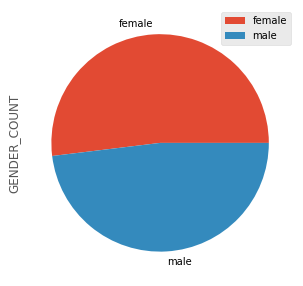

In [150]:
plot = df.plot.pie(y='GENDER_COUNT', labels=[df.iloc[0][0], df.iloc[1][0]], figsize=(5, 5))

***QUERY*** **3**: Ratio by Ethnicity

In [0]:
QUERY = '''SELECT
  population,
  population_description,
  population_count,
   ROUND((population_count/TOTAL),2) AS population_ratio
from(
    SELECT
    population,
    population_description,
    super_population,
    super_population_description,
    COUNT(population) AS population_count,
    SUM(COUNT(population)) OVER () as TOTAL
  FROM
    `genomics-public-data.1000_genomes.sample_info` 
  WHERE
    In_Phase1_Integrated_Variant_Set = TRUE
  GROUP BY
    population,
    population_description,
    super_population,
    super_population_description
    ORDER BY 
    population,
    population_description,
    super_population,
    super_population_description
    )
    '''

In [202]:
bq_assistant.estimate_query_size(QUERY)

0.0001673717051744461

In [0]:
df = bq_assistant.query_to_pandas_safe(QUERY)

In [204]:
#To explore the results:
print('Size of dataframe: {} Bytes'.format(int(df.memory_usage(index=True, deep=True).sum())))
df.head()

Size of dataframe: 2400 Bytes


,population,population_description,population_count,population_ratio
0,ASW,African Ancestry in Southwest US,61,0.06
1,CEU,Utah residents with Northern and Western Europ...,85,0.08
2,CHB,"Han Chinese in Bejing, China",97,0.09
3,CHS,"Southern Han Chinese, China",100,0.09
4,CLM,"Colombian in Medellin, Colombia",60,0.05


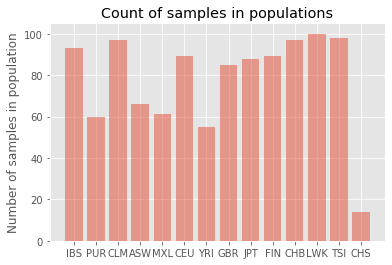

In [169]:
objects = ('IBS','PUR','CLM','ASW','MXL','CEU','YRI','GBR','JPT','FIN','CHB','LWK', 'TSI','CHS')
y_pos = np.arange(len(objects))
performance = [df.iloc[0][2],df.iloc[1][2],df.iloc[2][2],df.iloc[3][2],df.iloc[4][2],df.iloc[5][2],
df.iloc[6][2],df.iloc[7][2],df.iloc[8][2],df.iloc[9][2],df.iloc[10][2],df.iloc[11][2],df.iloc[12][2],df.iloc[13][2]]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number of samples in population')
plt.title('Count of samples in populations')

plt.show()

***QUERY*** **4**: Ratio of Ethnicities grouped by super population

In [0]:
%%bigquery --project subtle-signal-258712 df
SELECT
  super_population,
  super_population_description,
  super_population_count,
  ROUND((super_population_count/TOTAL),2) AS super_population_ratio
from(
  SELECT
    super_population,
    super_population_description,
    COUNT(population) AS super_population_count,
    SUM(COUNT(population)) OVER() as TOTAL
  FROM
    `genomics-public-data.1000_genomes.sample_info` 
  WHERE
    In_Phase1_Integrated_Variant_Set = TRUE
  GROUP BY
    super_population,
    super_population_description
)

In [171]:
bq_assistant.estimate_query_size(QUERY)

6.825756281614304e-05

In [0]:
df = bq_assistant.query_to_pandas_safe(QUERY)

In [173]:
#To explore the results:
print('Size of dataframe: {} Bytes'.format(int(df.memory_usage(index=True, deep=True).sum())))
df.head()

Size of dataframe: 693 Bytes


,super_population,super_population_description,super_population_count,super_population_ratio
0,EUR,European,379,0.35
1,AMR,American,181,0.17
2,EAS,East Asian,286,0.26
3,AFR,African,246,0.23


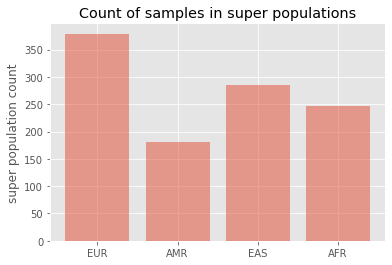

In [182]:
objects = [df.iloc[0]['super_population'],df.iloc[1]['super_population'],df.iloc[2]['super_population'],df.iloc[3]['super_population']]
y_pos = np.arange(len(objects))
performance = [df.iloc[0]['super_population_count'],df.iloc[1]['super_population_count'],df.iloc[2]['super_population_count'],df.iloc[3]['super_population_count']]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('super population count')
plt.title('Count of samples in super populations')

plt.show()

***QUERY*** **5**: Ratio of Ethnicities grouped by Gender

In [0]:
%%bigquery --project subtle-signal-258712 df
SELECT
  population,
  gender,
  population_count,
  ROUND((population_count/TOTAL),2) AS population_ratio
from(
  SELECT
    gender,
    population,
    COUNT(population) AS population_count,
    SUM(COUNT(population)) OVER () AS TOTAL
     FROM
    `genomics-public-data.1000_genomes.sample_info` 
  WHERE
    In_Phase1_Integrated_Variant_Set = TRUE
  GROUP BY
    gender,
    population)
ORDER BY
  population,
  gender

In [175]:
bq_assistant.estimate_query_size(QUERY)

4.015117883682251e-05

In [0]:
df = bq_assistant.query_to_pandas_safe(QUERY)

In [177]:
#To explore the results:
print('Size of dataframe: {} Bytes'.format(int(df.memory_usage(index=True, deep=True).sum())))
df.head()

Size of dataframe: 3992 Bytes


,population,gender,population_count,population_ratio
0,ASW,female,37,0.03
1,ASW,male,24,0.02
2,CEU,female,40,0.04
3,CEU,male,45,0.04
4,CHB,female,53,0.05


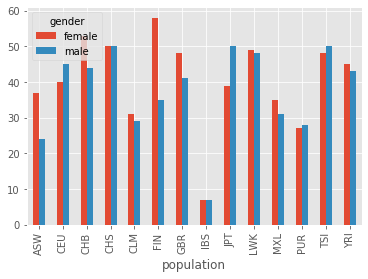

In [187]:
df.pivot(index='population', columns='gender', values='population_count').plot(kind='bar')

***QUERY*** **6**: Distribution of family size

In [0]:
%%bigquery --project subtle-signal-258712 df
SELECT
num_family_members AS family_size,
COUNT(num_family_members) AS num_families_of_size
FROM (
  SELECT
  family_id,
  COUNT(family_id) AS num_family_members
  FROM
   `genomics-public-data.1000_genomes.sample_info` 
  WHERE
  In_Phase1_Integrated_Variant_Set = TRUE
  GROUP BY
  family_id)
GROUP BY
family_size

In [0]:
bq_assistant.estimate_query_size(QUERY)

2.4281442165374756e-05

In [0]:
df = bq_assistant.query_to_pandas_safe(QUERY)

In [0]:
#To explore the results:
print('Size of dataframe: {} Bytes'.format(int(df.memory_usage(index=True, deep=True).sum())))
df.head()

Size of dataframe: 192 Bytes


,family_size,num_families_of_size
0,1,636
1,2,204
2,3,12
3,4,3


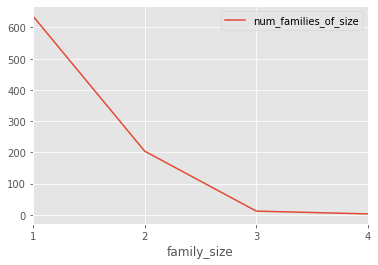

In [190]:
df.plot(y='num_families_of_size', x='family_size', xticks=(1,2,3,4))

**2.2** **EXPLORING VARIANT DATA**


***QUERY*** **1**: Min/Max Chromosomal Positions of Variants

In [0]:
QUERY ='''SELECT
  CAST(reference_name AS INT64) AS chromosome,
   MIN(start) AS min,
   MAX(start) AS max
 FROM
   `genomics-public-data.1000_genomes.variants`
 WHERE reference_name NOT IN ("X", "Y", "MT")
 GROUP BY
   chromosome
   ORDER BY
    chromosome'''
   #* A basic sanity check
#Chromosomes 13,14,15,21,22 have abnormally high min positions.
#Chromosome 7 has low min position.
#Hard to sequence regions?

In [127]:
bq_assistant.estimate_query_size(QUERY)

0.42134151980280876

In [0]:
df = bq_assistant.query_to_pandas_safe(QUERY)

In [212]:
#To explore the results:
print('Size of dataframe: {} Bytes'.format(int(df.memory_usage(index=True, deep=True).sum())))
df.head()

Size of dataframe: 656 Bytes


,chromosome,min,max
0,1,10582,249239464
1,2,10132,243188918
2,3,60156,197946620
3,4,10239,191043592
4,5,11939,180885154


In [0]:
dff = pd.DataFrame({'min': np.log(df['min']), 'max': np.log(df['max'])}, index=df['chromosome'])
dff.plot.bar(rot=0)

***QUERY*** **2**: Frequency of Variant Types Per Chromosome

In [0]:
QUERY ='''SELECT
  CAST(reference_name AS INT64) AS chromosome,
  vt AS variant_type,
  COUNT(1) AS cnt
 FROM
   `genomics-public-data.1000_genomes.variants`
 WHERE reference_name NOT IN ("X", "Y", "MT")
 GROUP BY
   chromosome,
   variant_type '''
   #* Mostly SNPs. * Very few structural variants. * Note suppressed zero.

In [214]:
bq_assistant.estimate_query_size(QUERY)

0.31291691306978464

In [0]:
df = bq_assistant.query_to_pandas_safe(QUERY)

In [216]:
#To explore the results:
print('Size of dataframe: {} Bytes'.format(int(df.memory_usage(index=True, deep=True).sum())))
df.head()

Size of dataframe: 5166 Bytes


,chromosome,variant_type,cnt
0,22,SNP,475371
1,13,INDEL,52983
2,3,INDEL,98512
3,2,INDEL,116562
4,10,SV,651


In [0]:
pivot_df = df.pivot(index='chromosome', columns='variant_type', values='cnt')
pivot_df.plot.bar(stacked=True,  figsize=(10,7))

***QUERY*** **3**: Types of SNP pairs (looks at both alleles)

In [218]:
%%bigquery --project subtle-signal-258712 --use_legacy_sql
SELECT
  reference_bases AS reference,
  CONCAT(
    IF(first_allele=0,
       reference_bases,
       alternate_bases),
    "|",
    IF(second_allele=0,
       reference_bases,
       alternate_bases)
    ) AS alleles,
  COUNT(1) AS cnt,
FROM
     FLATTEN((SELECT 
         reference_name,
         reference_bases,
         alternate_bases,
         vt,
         NTH(1, call.genotype) WITHIN call AS first_allele,
         NTH(2, call.genotype) WITHIN call AS second_allele
       FROM [genomics-public-data:1000_genomes.variants])
     , call)
OMIT RECORD IF
     reference_name IN ("X", "Y", "MT")
  OR first_allele < 0
  OR second_allele < 0
  OR vt != "SNP"
GROUP BY
  reference,
  alleles
  #Total count is #genomes * #SNPs. * Same data - two views
#Red bars denote no mutation - both alleles equal reference.

#Why are A -> C,C and A-> G,G likely, but not A -> C,G or A -> G,C?

#Note that A & T rows are reverses of each other, as are C & G rows.

,reference,alleles,cnt
0,C,T|C,220478193
1,C,C|A,52266563
2,C,G|C,52114972
3,T,T|G,47376201
4,T,A|A,52008013
5,T,C|C,270892281
6,G,C|C,65886211
7,G,G|C,52175403
8,A,A|T,42098551
9,C,A|C,52251229


In [0]:
bq_assistant.estimate_query_size(QUERY)

In [0]:
df = bq_assistant.query_to_pandas_safe(QUERY)

In [0]:
#To explore the results:
print('Size of dataframe: {} Bytes'.format(int(df.memory_usage(index=True, deep=True).sum())))
df.head()